# Imports and Preprocessing

In [ ]:
#!pip install torch-geometric==2.0.1
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 85.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.1 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-duos1464
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-duos1464
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 5d1b8987e52ddead470973c611c5b6b1bf935d99
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=11

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set target image size and paths
target = 256
dataPath = '/content/drive/MyDrive/Mini_Project/Concise_data'
batch_size = 8

def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0)
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    #image = preprocess_input(image)
    return image

# Data generators
trainDataGen = ImageDataGenerator(
    preprocessing_function=addNoise,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=360,
    shear_range=30,
    brightness_range=(0.95, 1.05),
    fill_mode='constant',
    cval=0,
    zoom_range=0.05
)

trainGen = trainDataGen.flow_from_directory(
    batch_size=batch_size,
    shuffle=True,
    class_mode="binary",
    target_size=(target, target),
    directory=os.path.join(dataPath, 'train'),
    color_mode='rgb'
)

valDataGen = ImageDataGenerator(rescale=1.0 / 255.0)
valGen = valDataGen.flow_from_directory(
    batch_size=1,
    class_mode="binary",
    target_size=(target, target),
    directory=os.path.join(dataPath, 'validation'),
    color_mode='rgb'
)

testDataGen = ImageDataGenerator(rescale=1.0 / 255.0)
testGen = testDataGen.flow_from_directory(
    batch_size=1,
    class_mode="binary",
    target_size=(target, target),
    directory=os.path.join(dataPath, 'test'),
    color_mode='rgb'
)

Found 4000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


# Building CNN Model

In [ ]:
# Build CNN model with ConvNeXt Tiny
def getModel(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    transfer = tf.keras.applications.ConvNeXtTiny(
        weights='imagenet', include_preprocessing=True, include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    model_output = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = getModel(image_size=target, num_classes=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=1, min_lr=1e-5)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='val-best.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_prestem_no… │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stem        │ (None, 64, 64, 96)     │          4,896 │ convnext_tiny_prestem… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │          4,800 │ convnext_tiny_stem[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │            192 │ convnext_tiny_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 384)    │         37,248 │ convnext_tiny_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 384)    │              0 │ convnext_tiny_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │         36,960 │ convnext_tiny_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │             96 │ convnext_tiny_stage_0… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │              0 │ convnext_tiny_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 96)     │              0 │ convnext_tiny_stem[0]… │
│                           │                        │                │ convnext_tiny_stage_0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │          4,800 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 64, 64, 96)     │            192 │ convnext_tiny_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0

 Total params: 27,869,409 (106.31 MB)

 Trainable params: 27,869,409 (106.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    trainGen,
    steps_per_epoch=len(trainGen),
    validation_data=valGen,
    validation_steps=len(valGen),
    epochs=20,
    callbacks=[reduce_lr, model_checkpoint_callback]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - auc: 0.7327 - binary_accuracy: 0.6592 - loss: 158.7481 - precision: 0.6558 - recall: 0.6556 - val_auc: 0.4974 - val_binary_accuracy: 0.5000 - val_loss: 41.1744 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: auc,binary_accuracy,loss,precision,recall,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 216ms/step - auc: 0.9283 - binary_accuracy: 0.8589 - loss: 22.6666 - precision: 0.8489 - recall: 0.8747 - val_auc: 0.5208 - val_binary_accuracy: 0.5000 - val_loss: 1.6125 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 110s 215ms/step - auc: 0.9443 - binary_accuracy: 0.8736 - loss: 0.9649 - precision: 0.8713 - recall: 0.8801 - val_auc: 0.5000 - val_binary_accuracy: 0.5000 - val_loss: 1.0351 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save('pretrained.keras')
model.load_weights('/content/val-best.keras')
model.evaluate(testGen)

770/770 ━━━━━━━━━━━━━━━━━━━━ 221s 288ms/step - auc: 0.4658 - binary_accuracy: 0.5022 - loss: 0.8217 - precision: 0.5022 - recall: 0.9987


[0.8218686580657959, 0.5, 0.4623376727104187, 0.5, 1.0]

# Building GNN Model

In [ ]:
# Continue with existing imports
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import numpy as np

# Extract features from the CNN model
def extract_cnn_features(base_model):
    """Extract intermediate features from ConvNeXtTiny"""
    selected_layers = ['convnext_tiny/stage_0/block_0/layer_scale_2',
                      'convnext_tiny/stage_1/block_0/layer_scale_2']
    return Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer(name).output for name in selected_layers]
    )

class GraphCreationLayer(layers.Layer):
    def __init__(self, k_neighbors=8, **kwargs):
        super().__init__(**kwargs)
        self.k_neighbors = k_neighbors

    def call(self, features):
        # Get spatial dimensions
        height, width = features.shape[1:3]
        channels = features.shape[-1]

        # Reshape features to [batch, nodes, channels]
        node_features = tf.reshape(features, [-1, height * width, channels])

        # Create fixed spatial edge patterns
        indices = []
        for i in range(height):
            for j in range(width):
                current = i * width + j
                if j < width - 1:  # right
                    indices.append([current, current + 1])
                if i < height - 1:  # down
                    indices.append([current, current + width])
                if i < height - 1 and j < width - 1:  # diagonal
                    indices.append([current, current + width + 1])

        edge_indices = tf.constant(indices, dtype=tf.int32)
        return node_features, edge_indices

class GNNLayer(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        node_features_shape, _ = input_shape
        self.transform = layers.Dense(self.units, activation='relu')
        self.attention = layers.Dense(1, activation='tanh')
        self.combine = layers.Dense(self.units, activation='relu')
        super().build(input_shape)

    def call(self, inputs):
        node_features, edge_indices = inputs
        batch_size = tf.shape(node_features)[0]
        num_nodes = tf.shape(node_features)[1]

        # Transform node features
        node_features = self.transform(node_features)

        # Prepare indices for gathering from batched tensor
        batch_range = tf.range(batch_size)
        batch_range = tf.expand_dims(batch_range, -1)  # [batch_size, 1]
        batch_range = tf.tile(batch_range, [1, tf.shape(edge_indices)[0]])  # [batch_size, num_edges]
        batch_range = tf.reshape(batch_range, [-1])  # [batch_size * num_edges]

        # Repeat edge indices for each batch
        edge_indices_repeated = tf.tile(tf.expand_dims(edge_indices, 0), [batch_size, 1, 1])
        edge_indices_flat = tf.reshape(edge_indices_repeated, [-1, 2])

        # Gather source and target nodes
        gather_indices = tf.stack([batch_range, tf.reshape(edge_indices_flat[:, 0], [-1])], axis=1)
        source_nodes = tf.gather_nd(node_features, gather_indices)

        gather_indices = tf.stack([batch_range, tf.reshape(edge_indices_flat[:, 1], [-1])], axis=1)
        target_nodes = tf.gather_nd(node_features, gather_indices)

        # Compute attention scores
        edge_features = tf.concat([source_nodes, target_nodes], axis=-1)
        attention_weights = tf.nn.softmax(self.attention(edge_features), axis=0)

        # Weight the target nodes
        weighted_messages = attention_weights * target_nodes

        # Reshape for scattering
        weighted_messages = tf.reshape(weighted_messages, [batch_size, -1, self.units])

        # Aggregate messages using scatter_nd
        scattered_shape = tf.stack([batch_size, num_nodes, self.units])
        scattered_messages = tf.zeros(scattered_shape)

        # Create scatter indices
        scatter_indices = tf.stack([
            tf.repeat(tf.range(batch_size), tf.shape(edge_indices)[0]),
            tf.reshape(edge_indices_flat[:, 0], [-1])
        ], axis=1)

        scattered_messages = tf.tensor_scatter_nd_add(
            scattered_messages,
            scatter_indices,
            tf.reshape(weighted_messages, [-1, self.units])
        )

        # Combine with original features
        output = self.combine(tf.concat([node_features, scattered_messages], axis=-1))
        return output

def getModelWithGNN(image_size, num_classes):
    # Input layer
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))

    # Base CNN
    base_cnn = tf.keras.applications.ConvNeXtTiny(
        weights='imagenet',
        include_preprocessing=True,
        include_top=False,
        input_tensor=model_input
    )

    # Extract CNN features
    cnn_features = base_cnn.output

    # Convert to graph structure
    node_features, edge_indices = GraphCreationLayer()(cnn_features)

    # Apply GNN layers
    x = node_features
    for units in [256, 128, 64]:
        x = GNNLayer(units)([x, edge_indices])

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)

    # Output heads
    classification_output = layers.Dense(1, activation='sigmoid', name='classification')(x)
    ungradability_output = layers.Dense(1, activation='linear', name='ungradability')(x)

    return Model(inputs=model_input, outputs=[classification_output, ungradability_output])

# Create and compile the model
model = getModelWithGNN(image_size=target, num_classes=1)

# Compile with multiple outputs
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'classification': 'binary_crossentropy',
        'ungradability': 'mse'
    },
    loss_weights={
        'classification': 1.0,
        'ungradability': 0.5
    },
    metrics={
        'classification': [
            'binary_accuracy',
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ],
        'ungradability': ['mae']
    }
)

# Modified data generator (unchanged from previous version)
def enhanced_generator(base_generator, include_ungradability=True):
    while True:
        batch_x, batch_y = next(base_generator)
        if include_ungradability:
            ungradability = np.random.uniform(0, 1, size=(batch_x.shape[0], 1))
            yield batch_x, {'classification': batch_y, 'ungradability': ungradability}
        else:
            yield batch_x, {'classification': batch_y, 'ungradability': np.zeros((batch_x.shape[0], 1))}

# Setup generators
train_gen_enhanced = enhanced_generator(trainGen)
val_gen_enhanced = enhanced_generator(valGen, include_ungradability=False)
test_gen_enhanced = enhanced_generator(testGen, include_ungradability=False)

# Train the model
history = model.fit(
    train_gen_enhanced,
    steps_per_epoch=len(trainGen),
    validation_data=val_gen_enhanced,
    validation_steps=len(valGen),
    epochs=20,
    callbacks=[reduce_lr, model_checkpoint_callback]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - classification_auc_2: 0.7146 - classification_binary_accuracy: 0.6527 - classification_loss: 0.5975 - classification_precision_2: 0.6399 - classification_recall_2: 0.6835 - loss: 40.0683 - ungradability_loss: 0.0463 - ungradability_mae: 0.2604 - val_classification_auc_2: 0.5000 - val_classification_binary_accuracy: 0.5000 - val_classification_loss: 0.7178 - val_classification_precision_2: 0.0000e+00 - val_classification_recall_2: 0.0000e+00 - val_loss: 27.1543 - val_ungradability_loss: 0.1185 - val_ungradability_mae: 0.4868 - learning_rate: 1.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 216ms/step - classification_auc_2: 0.9251 - classification_binary_accuracy: 0.8609 - classification_loss: 0.3476 - classification_precision_2: 0.8592 - classification_recall_2: 0.8629 - loss: 23.0777 - ungradability_loss: 0.0439 - ungradability_mae: 0.2549 - val_classification_auc_2: 0.5000 - val_classification_binary_accuracy: 0.5000 - 

In [ ]:
model.evaluate(test_gen_enhanced)

500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 203ms/step - classification_auc_2: 0.9950 - classification_binary_accuracy: 0.9683 - classification_loss: 0.0884 - classification_precision_2: 0.9792 - classification_recall_2: 0.9576 - loss: 0.1085 - ungradability_loss: 0.0000e+00 - ungradability_mae: 0.0000e+00


[0.10218124091625214,
 0.08205088973045349,
 0.0,
 0.9951422214508057,
 0.9707499742507935,
 0.979623019695282,
 0.9614999890327454,
 0.0]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Total number of batches in the generator
total_batches = len(testGen)
half_batches = total_batches // 4  # Use only half the batches

# Collect true and predicted labels
y_true, y_pred = [], []

for i, (batch_x, batch_y) in enumerate(test_gen_enhanced):
    if i >= half_batches:
        break
    # Predict the classification head
    predictions = model.predict(batch_x)
    pred_labels = (predictions[0] > 0.5).astype(int)
    y_pred.extend(pred_labels)
    y_true.extend(batch_y['classification'])

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])

print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

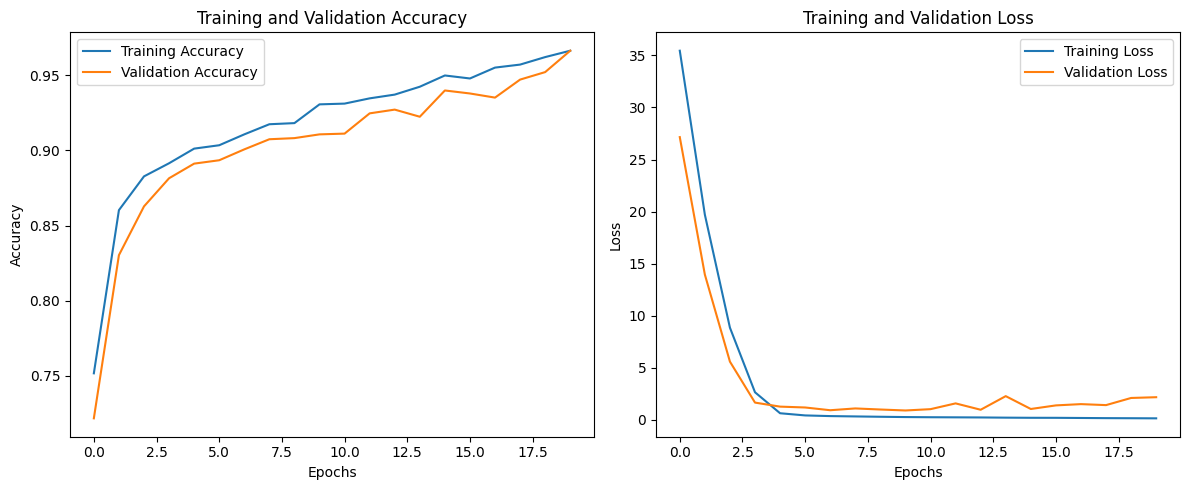

In [ ]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

# Accuracy
train_accuracy = history_dict['classification_binary_accuracy']
val_accuracy = history_dict['val_classification_binary_accuracy']

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
